# San Diego Burrito Analytics: Data characterization

Scott Cole

21 May 2016

This notebook characterizes the collection of reviewers of San Diego burritos including:

1. Metadata
2. How many of each kind of burrito have been reviewed?
3. For each of burrito dimension, what is the distribution of its scores across all samples?

### Default imports

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
sns.set_style("white")

### Load data

In [2]:
import util
df = util.load_burritos()
N = df.shape[0]

### Brief metadata

In [3]:
print 'Number of burritos:', df.shape[0]
print 'Number of restaurants:', len(df.Location.unique())
print 'Number of reviewers:', len(df.Reviewer.unique())
print 'Number of reviews by Scott:', df.Reviewer.value_counts()['Scott']
print 'Number of reviews by Emily:', df.Reviewer.value_counts()['Emily']

uniqlocidx = df.Location.drop_duplicates().index
print 'Percentage of taco shops with free chips:', np.round(100 - 100*df.Chips[uniqlocidx].isnull().sum()/np.float(len(df.Location.unique())),1)

Number of burritos: 276
Number of restaurants: 68
Number of reviewers: 58
Number of reviews by Scott: 98
Number of reviews by Emily: 42
Percentage of taco shops with free chips: 26.5


In [4]:
df.Location.unique()

array([u"donato's taco shop", u"oscar's mexican food", u'pollos maria',
       u"nico's taco shop", u'los primos mexican food',
       u"jv's mexican food", u"tony's fresh mexican food", u'taco stand',
       u"graciela's taco shop", u"rigoberto's taco shop la jolla",
       u"lolita's taco shop", u"lola's 7 up market & deli",
       u"colima's mexican food", u"rigoberto's taco shop",
       u"raul's mexican food", u'el zarape', u'el indio',
       u'cancun mexican & seafood', u'vallarta express',
       u'mikes taco club', u'la perla cocina', u'porkyland',
       u"rudy's taco shop", u'california burritos',
       u"jorge's mexicatessen", u"senor grubby's",
       u'mi asador mexican & seafood', u'sotos mexican food',
       u"karina's taco shop", u"juanita's taco shop", u"goody's",
       u'taco surf pb', u"roberto's very mexican food",
       u'netos mexican food', u'el nopalito', u'los tacos', u'albertacos',
       u'el rey moro', u"papa chito's mexican food",
       u'el pueblo me

In [5]:
# Count of how many burritos each person has eaten
df['Reviewer'].value_counts()

Scott           98
Emily           42
Ricardo         14
Sage            12
Brent            8
Luis             8
Elynn            8
Richard          7
Erin             6
Marc             4
Tom              4
Matteo           4
Bankole          3
Hannah           3
Cris             2
Aga              2
Katie            2
Devleena         2
Tara             2
Kelsey           2
Sankha G         2
Shijia           2
Erik             2
Jeremy           2
Mike             2
Torben           1
Rob G            1
Jake             1
Ant              1
Rob L            1
Andy             1
Melissa G        1
Melissa N        1
Eli              1
Dan              1
Sandra           1
Leo              1
@synapticlee     1
Ashley G         1
Aaron S          1
Justin K         1
Alejandro        1
Daniel           1
Rob              1
Sam A            1
Shreejoy         1
Brad P           1
Brad             1
@danjlurie       1
Benni            1
Meghan           1
Alex             1
Javier      

### What types of burritos have been rated?

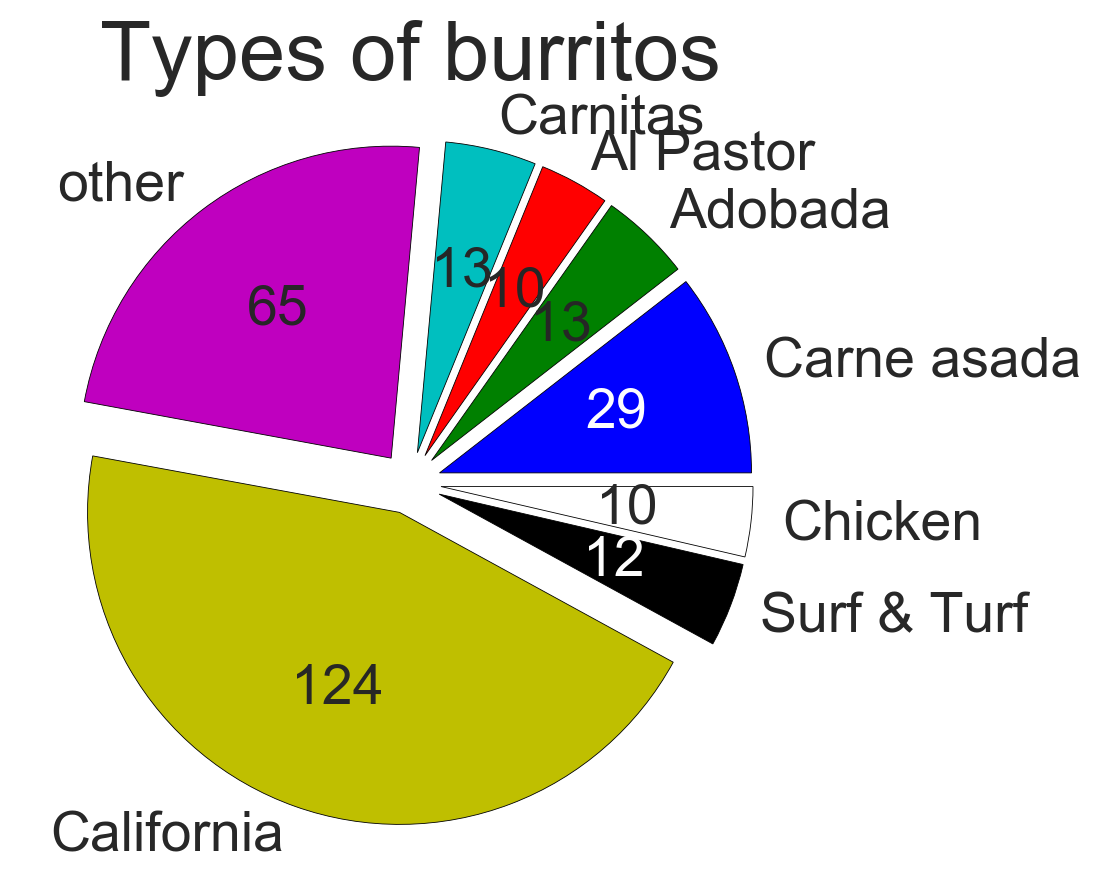

In [6]:
# Number of each type of burrito
def burritotypes(x, types = {'California':'cali', 'Carnitas':'carnita', 'Carne asada':'carne asada',
                             'Chicken':'chicken', 'Surf & Turf':'surf.*turf', 'Adobada':'adobad', 'Al Pastor':'pastor'}):
    import re
    T = len(types)
    Nmatches = {}
    for b in x:
        matched = False
        for t in types.keys():
            re4str = re.compile('.*'+types[t]+'.*', re.IGNORECASE)
            if np.logical_and(re4str.match(b) is not None, matched is False):
                try:
                    Nmatches[t] +=1
                except KeyError:
                    Nmatches[t] = 1
                matched = True
        if matched is False:
            try:
                Nmatches['other'] +=1
            except KeyError:
                Nmatches['other'] = 1
    return Nmatches

typecounts = burritotypes(df.Burrito)

plt.figure(figsize=(6,6))
ax = plt.axes([0.1, 0.1, 0.65, 0.65])

# The slices will be ordered and plotted counter-clockwise.
labels = typecounts.keys()
fracs = typecounts.values()
explode=[.1]*len(typecounts)

patches, texts, autotexts = plt.pie(fracs, explode=explode, labels=labels,
                autopct=lambda(p): '{:.0f}'.format(p * np.sum(fracs) / 100), shadow=False, startangle=0)
                # The default startangle is 0, which would start
                # the Frogs slice on the x-axis.  With startangle=90,
                # everything is rotated counter-clockwise by 90 degrees,
                # so the plotting starts on the positive y-axis.

plt.title('Types of burritos',size=30)
for t in texts:
    t.set_size(20)
for t in autotexts:
    t.set_size(20)
autotexts[0].set_color('w')
autotexts[6].set_color('w')

figname = 'burritotypes'
plt.savefig('C:/gh/fig/burrito/'+figname + '.png')

### Progress in number of burritos rated

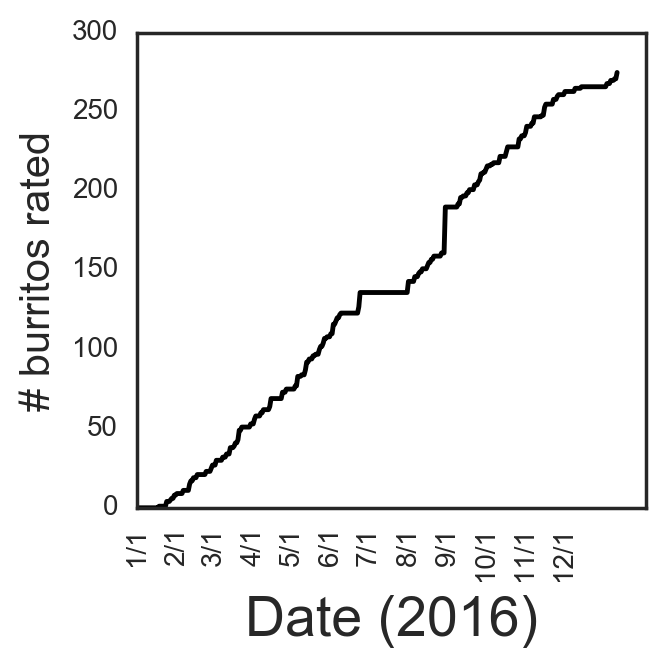

In [7]:
# Time series of ratings
import math

def dates2ts(dates):
    from datetime import datetime
    
    D = len(dates)
    start = datetime.strptime('1/1/2016','%m/%d/%Y')
    ts = np.zeros(D,dtype=int)
    for d in range(D):
        burrdate = datetime.strptime(df.Date[d],'%m/%d/%Y')
        diff = burrdate - start
        ts[d] = diff.days
    return ts

def cumburritos(days):
    from statsmodels.distributions.empirical_distribution import ECDF
    ecdf = ECDF(days)
    t = np.arange(days[-1]+1)
    return t, ecdf(t)*len(days)

def datelabels(startdate = '1/1/2016', M = 12):
    from datetime import datetime
    start = datetime.strptime(startdate,'%m/%d/%Y')
    datestrs = []
    ts = np.zeros(M)
    for m in range(M):
        datestrs.append(str(m+1) + '/1')
        burrdate = datetime.strptime(datestrs[m]+'/2016','%m/%d/%Y')
        diff = burrdate - start
        ts[m] = diff.days
    return datestrs, ts

burrdays = dates2ts(df.Date)
t, burrcdf = cumburritos(burrdays)
datestrs, datets = datelabels()

plt.figure(figsize=(3.5,3.5))
plt.plot(t,burrcdf,'k-')
plt.xlabel('Date (2016)',size=20)
plt.ylabel('# burritos rated',size=15)
plt.xticks(datets,datestrs,size=10, rotation='vertical')
plt.yticks(size=10)
plt.tight_layout()

figname = 'burritoprogress'
plt.savefig('C:/Users/Scott/Google Drive/qwm/burritos/figs/'+figname + '.png')

# Burrito dimension distributions

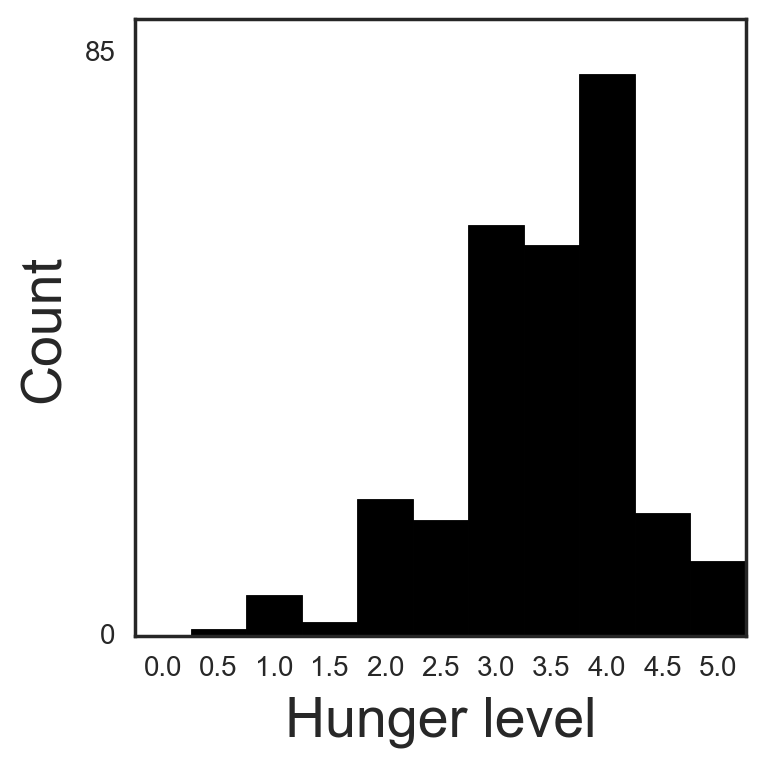

In [28]:
# Distribution of hunger level
plt.figure(figsize=(4,4))
n, _, _ = plt.hist(df.Hunger.dropna(),np.arange(-.25,5.5,.5),color='k')
plt.xlabel('Hunger level',size=20)
plt.xticks(np.arange(0,5.5,.5),size=10)
plt.xlim((-.25,5.25))
plt.ylabel('Count',size=20)
plt.yticks((0,int(math.ceil(np.max(n) / 5.)) * 5),size=10)
plt.tight_layout()

figname = 'hungerleveldist'
plt.savefig('C:/gh/fig/burrito/'+figname + '.png')

6.86626373626


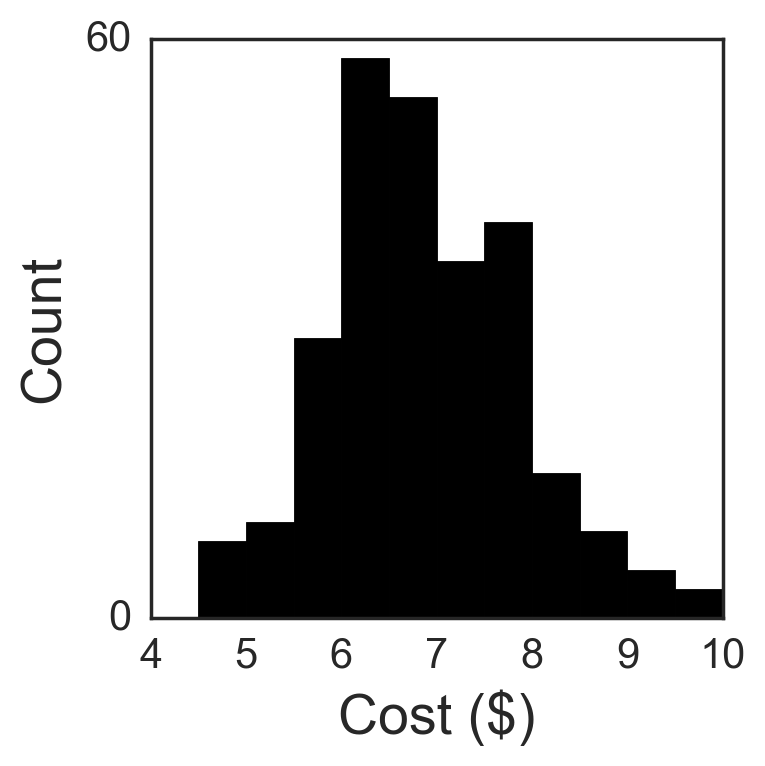

In [26]:
# Average burrito cost
plt.figure(figsize=(4,4))
n, _, _ = plt.hist(df.Cost.dropna(),np.arange(4,10.25,.5),color='k')
plt.xlabel('Cost ($)',size=20)
plt.xticks(np.arange(4,11,1),size=15)
plt.xlim((4,10))
plt.ylabel('Count',size=20)
plt.yticks((0,int(math.ceil(np.max(n) / 5.)) * 5),size=15)
plt.tight_layout()

figname = 'costdist'
plt.savefig('C:/gh/fig/burrito/'+figname + '.png')

print np.nanmean(df.Cost)

0.773942857143


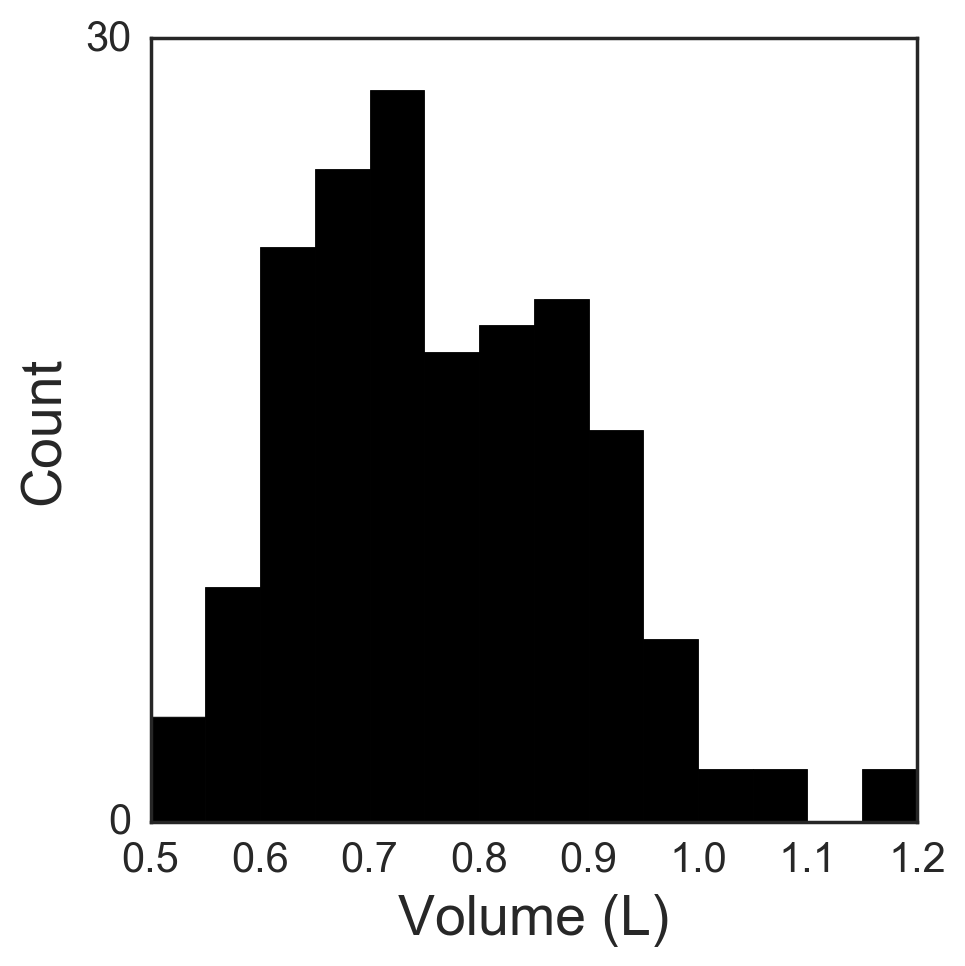

In [11]:
# Volume dist
plt.figure(figsize=(5,5))
n, _, _ = plt.hist(df.Volume.dropna(),np.arange(0.5,1.3,.05),color='k')
plt.xlabel('Volume (L)',size=20)
plt.xticks(np.arange(0.5,1.3,.1),size=15)
plt.xlim((0.5,1.2))
plt.ylabel('Count',size=20)
plt.yticks((0,int(math.ceil(np.max(n) / 5.)) * 5),size=15)
plt.tight_layout()

figname = 'volumedist'
plt.savefig('C:/gh/fig/burrito/'+figname + '.png')

print np.mean(df.Volume)

In [12]:
def metrichist(metricname):
    plt.figure(figsize=(5,5))
    n, _, _ = plt.hist(df[metricname].dropna(),np.arange(-.25,5.5,.5),color='k')
    plt.xlabel(metricname + ' rating',size=20)
    plt.xticks(np.arange(0,5.5,.5),size=15)
    plt.xlim((-.25,5.25))
    plt.ylabel('Count',size=20)
    plt.yticks((0,int(math.ceil(np.max(n) / 5.)) * 5),size=15)
    plt.tight_layout()
    
    if metricname == 'Meat:filling':
        metricname = 'meattofilling'
    figname = metricname + 'dist'
    plt.savefig('C:/gh/fig/burrito/'+figname + '.png')

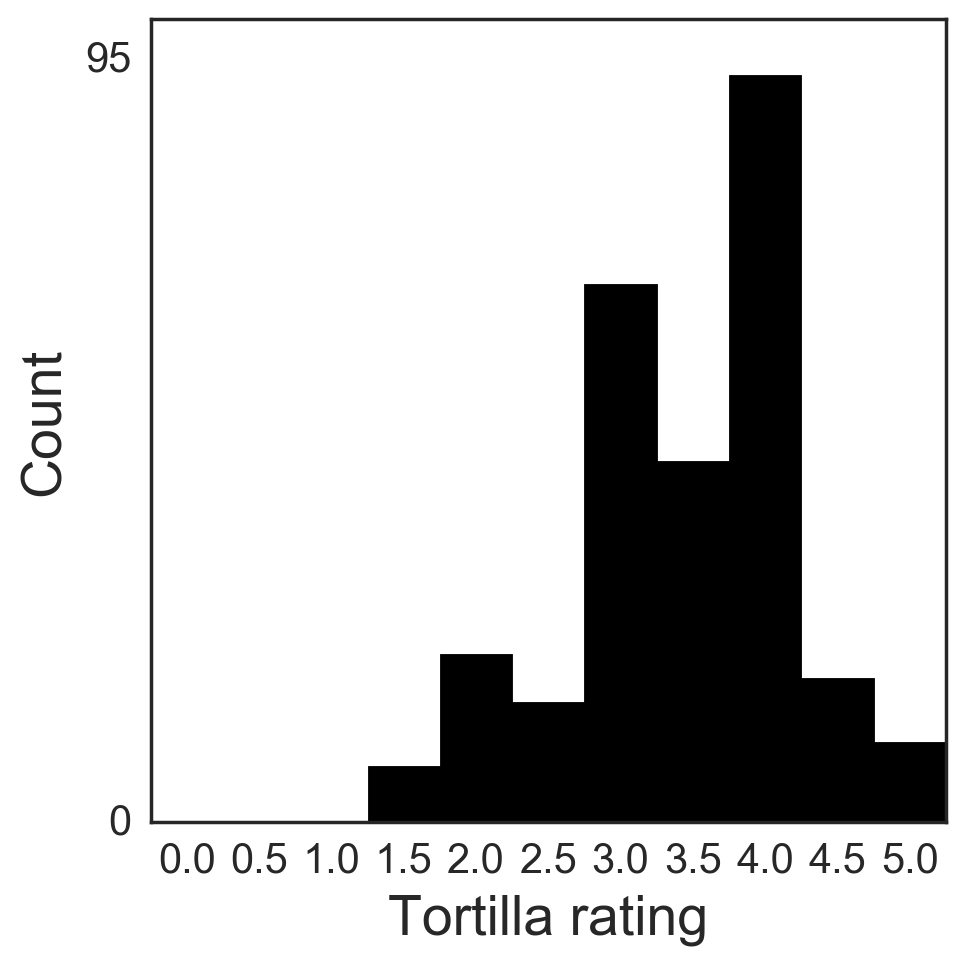

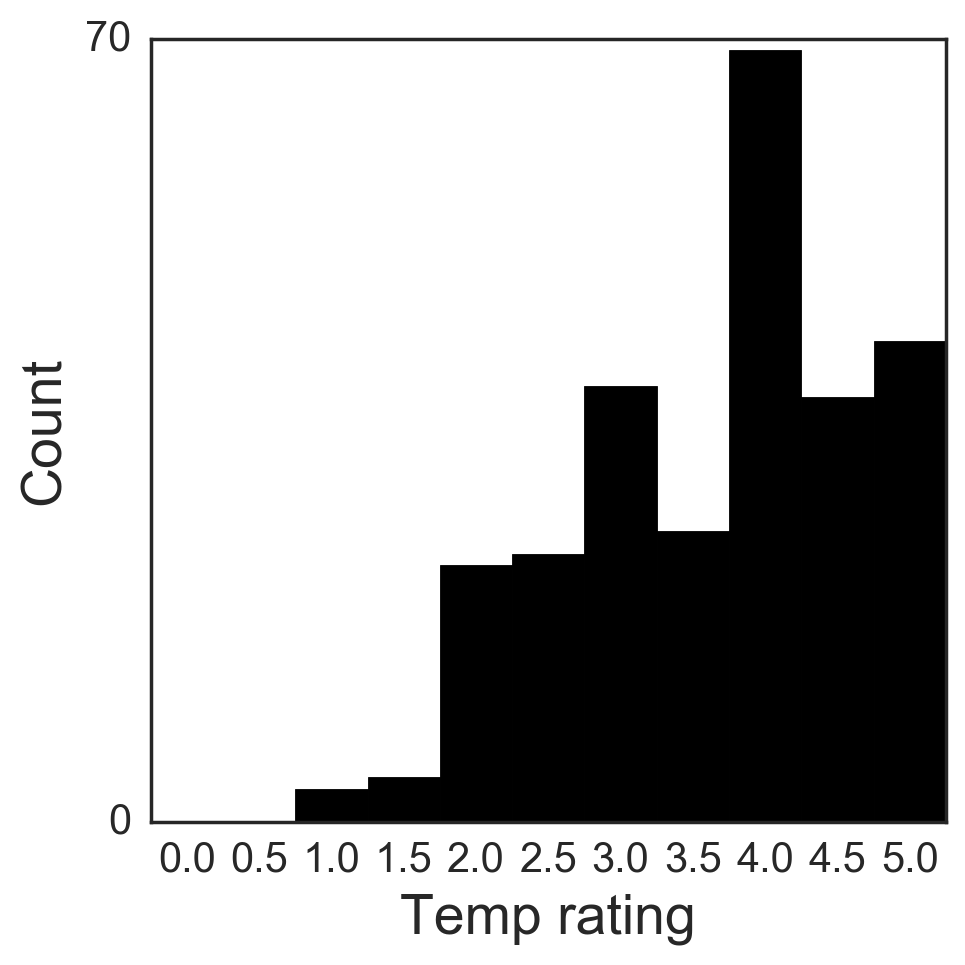

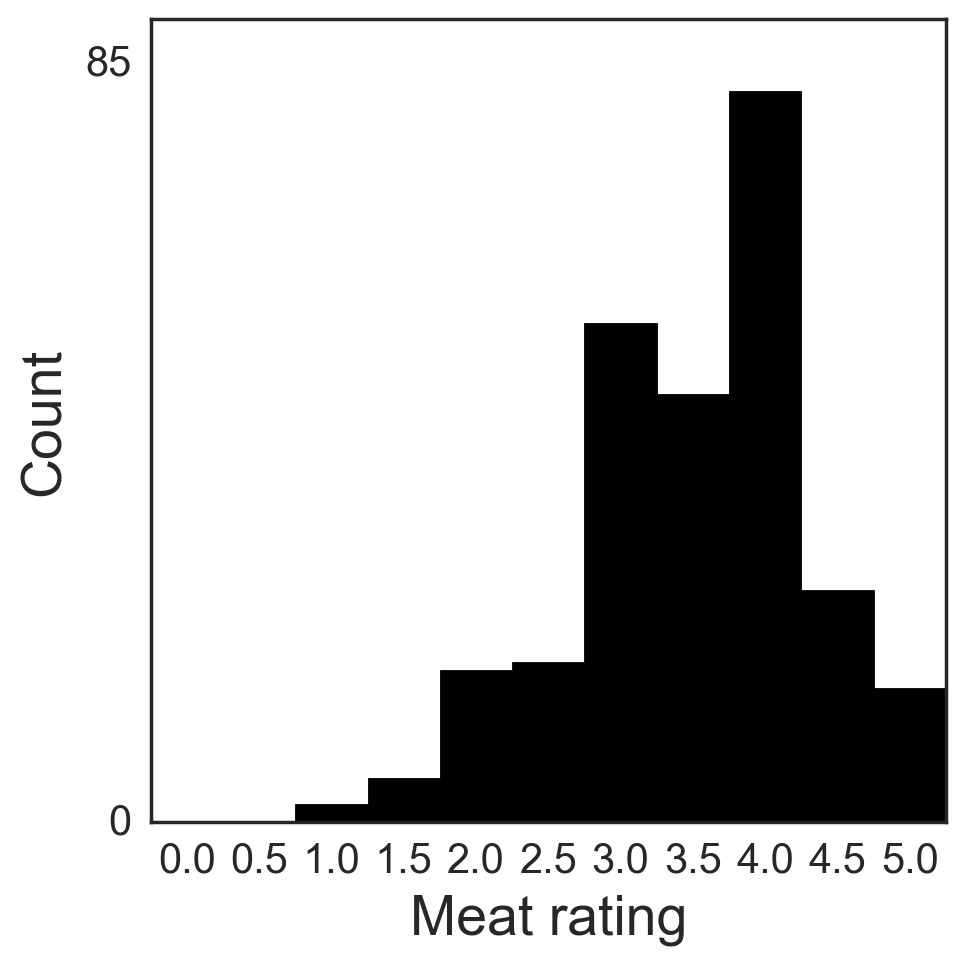

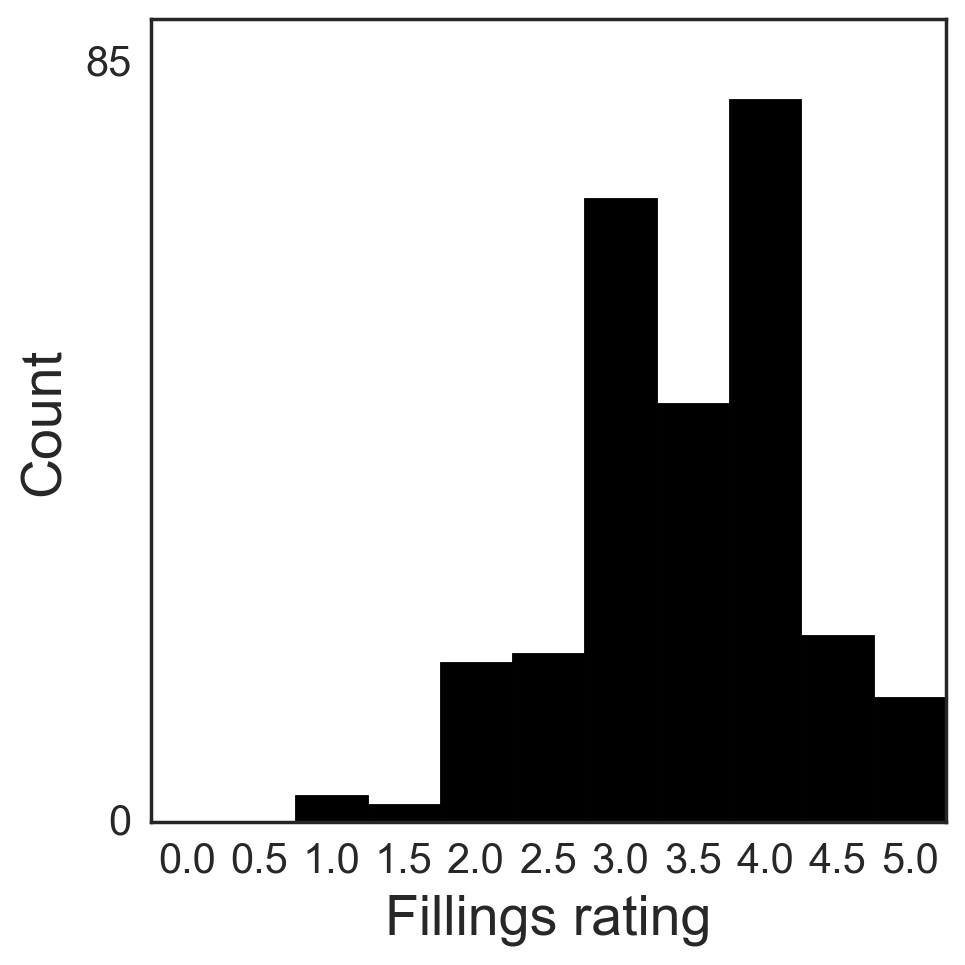

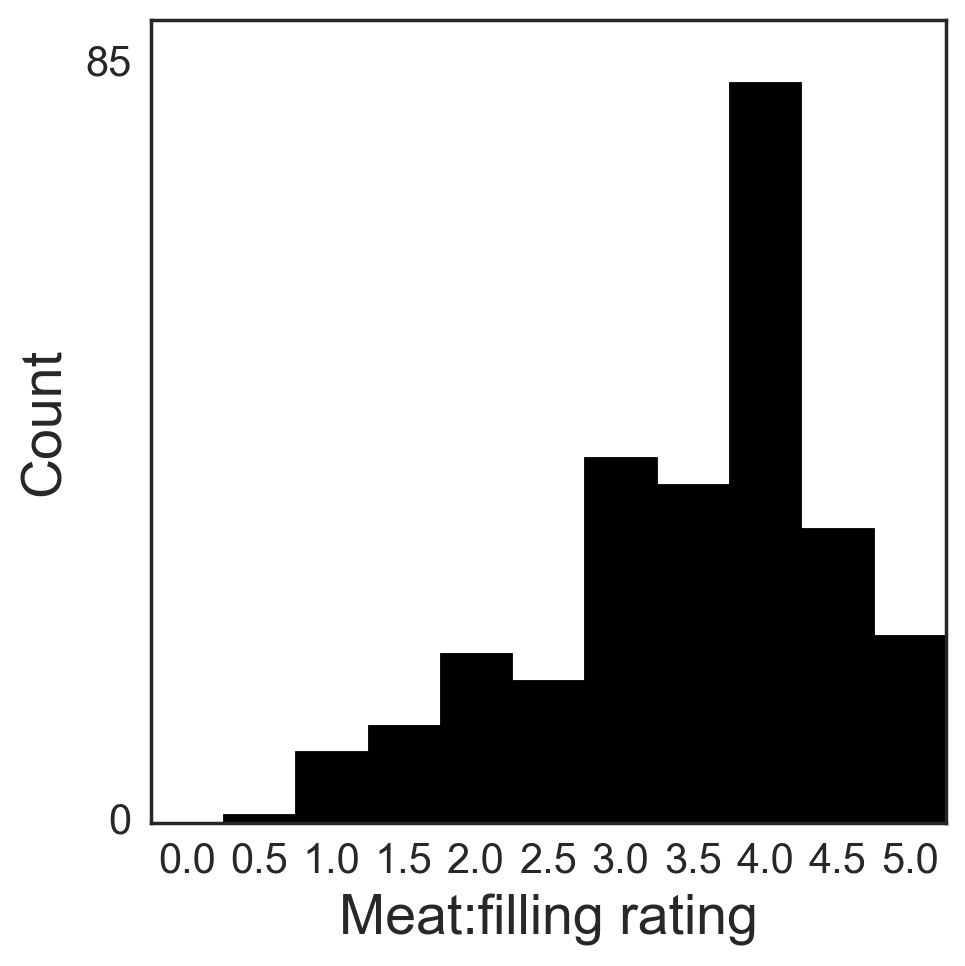

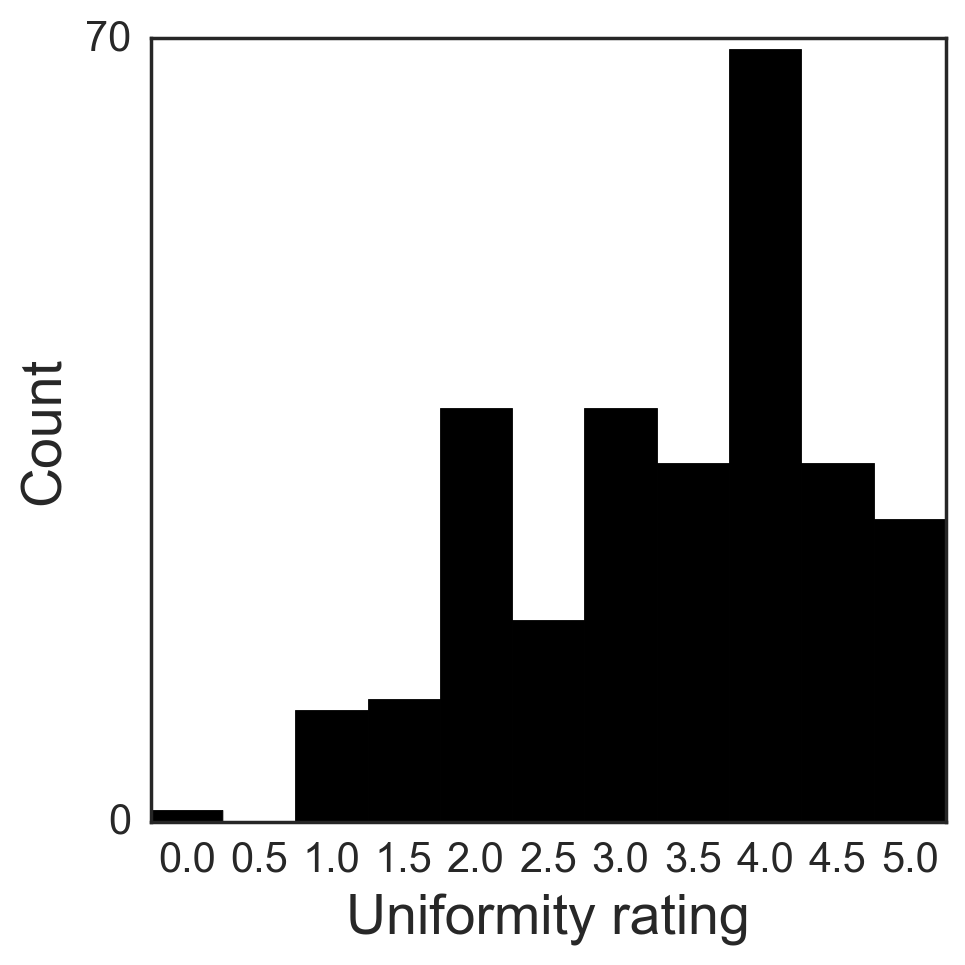

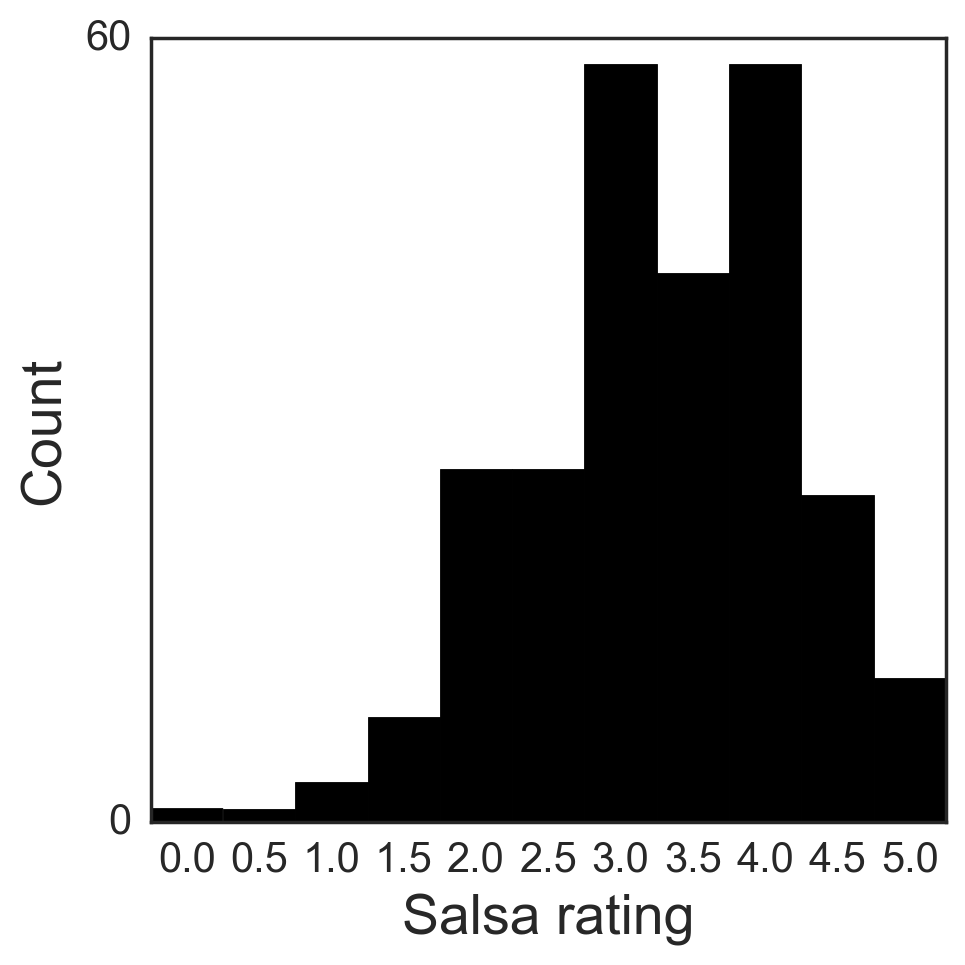

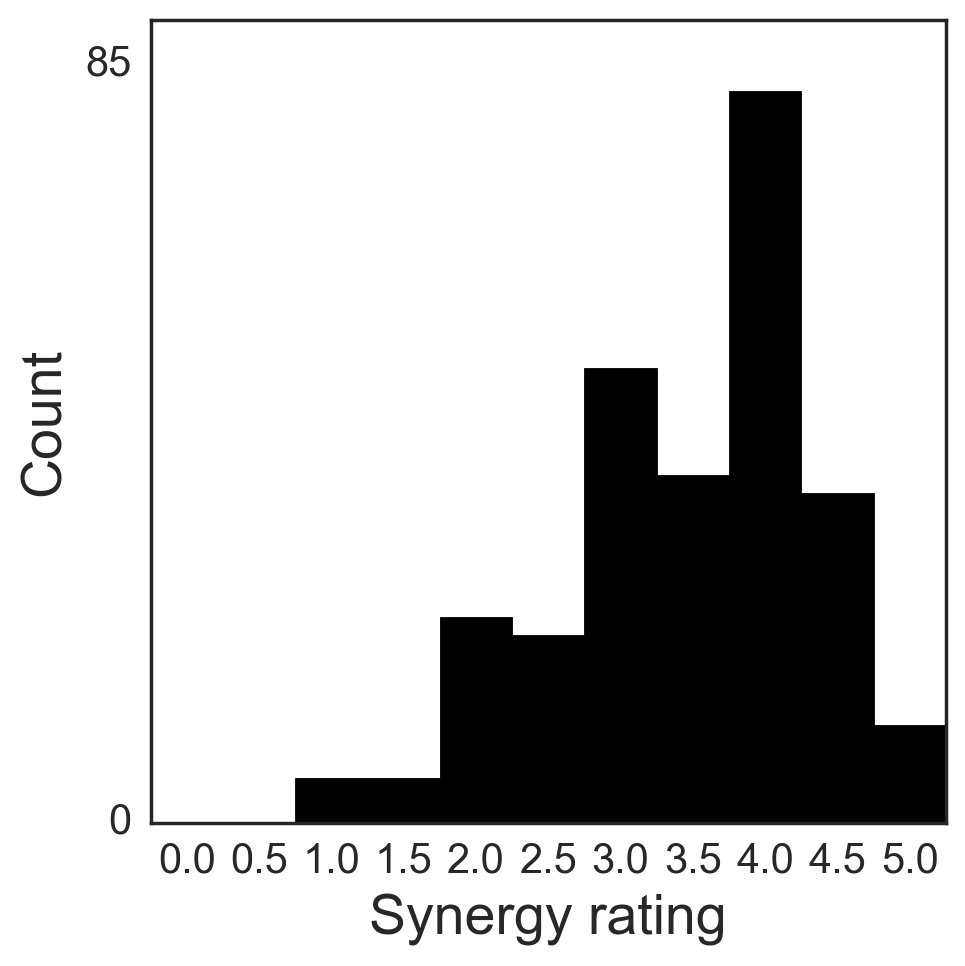

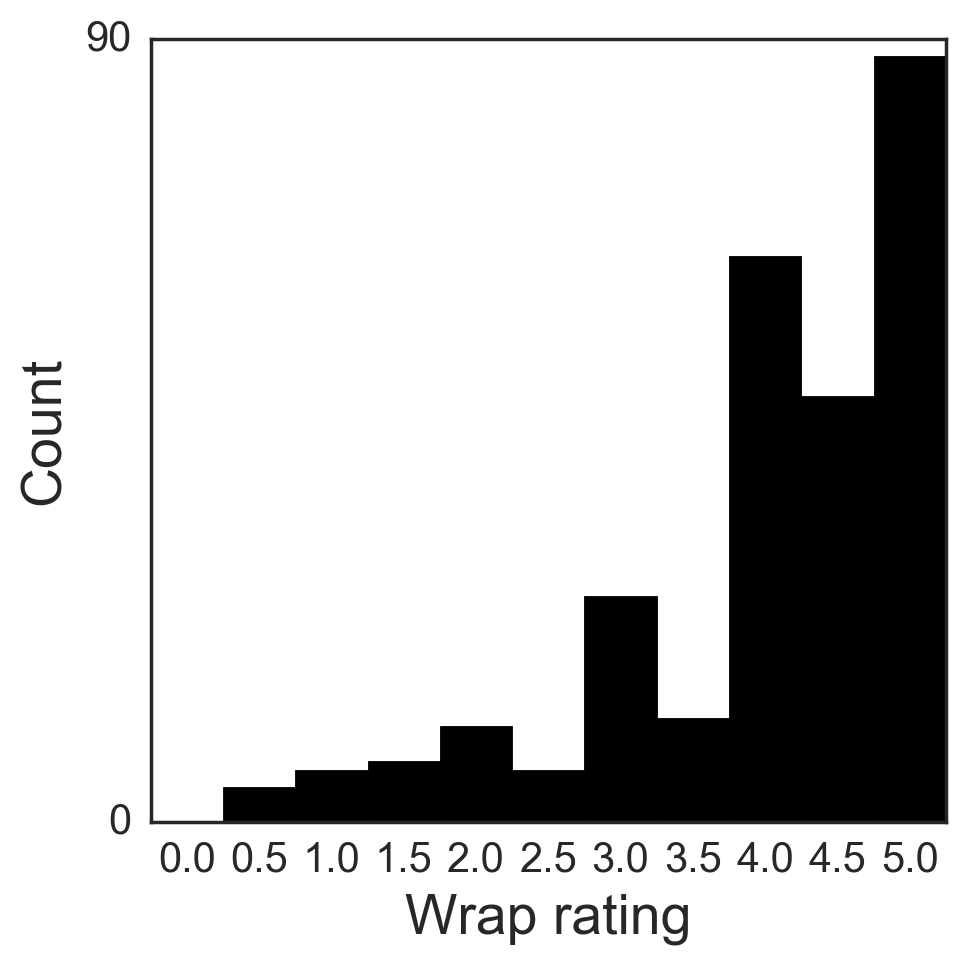

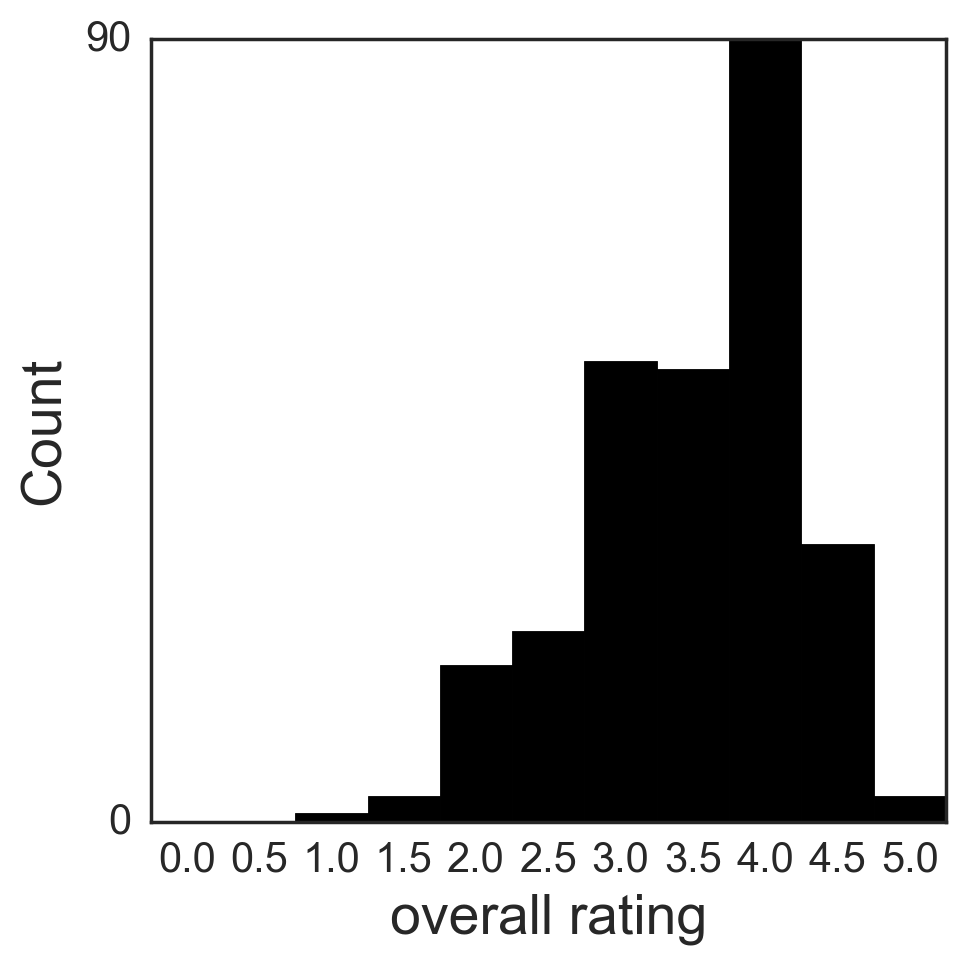

In [13]:
m_Hist = ['Tortilla','Temp','Meat','Fillings','Meat:filling','Uniformity','Salsa','Synergy','Wrap','overall']
for m in m_Hist:
    metrichist(m)

# Fraction of burritos recommended

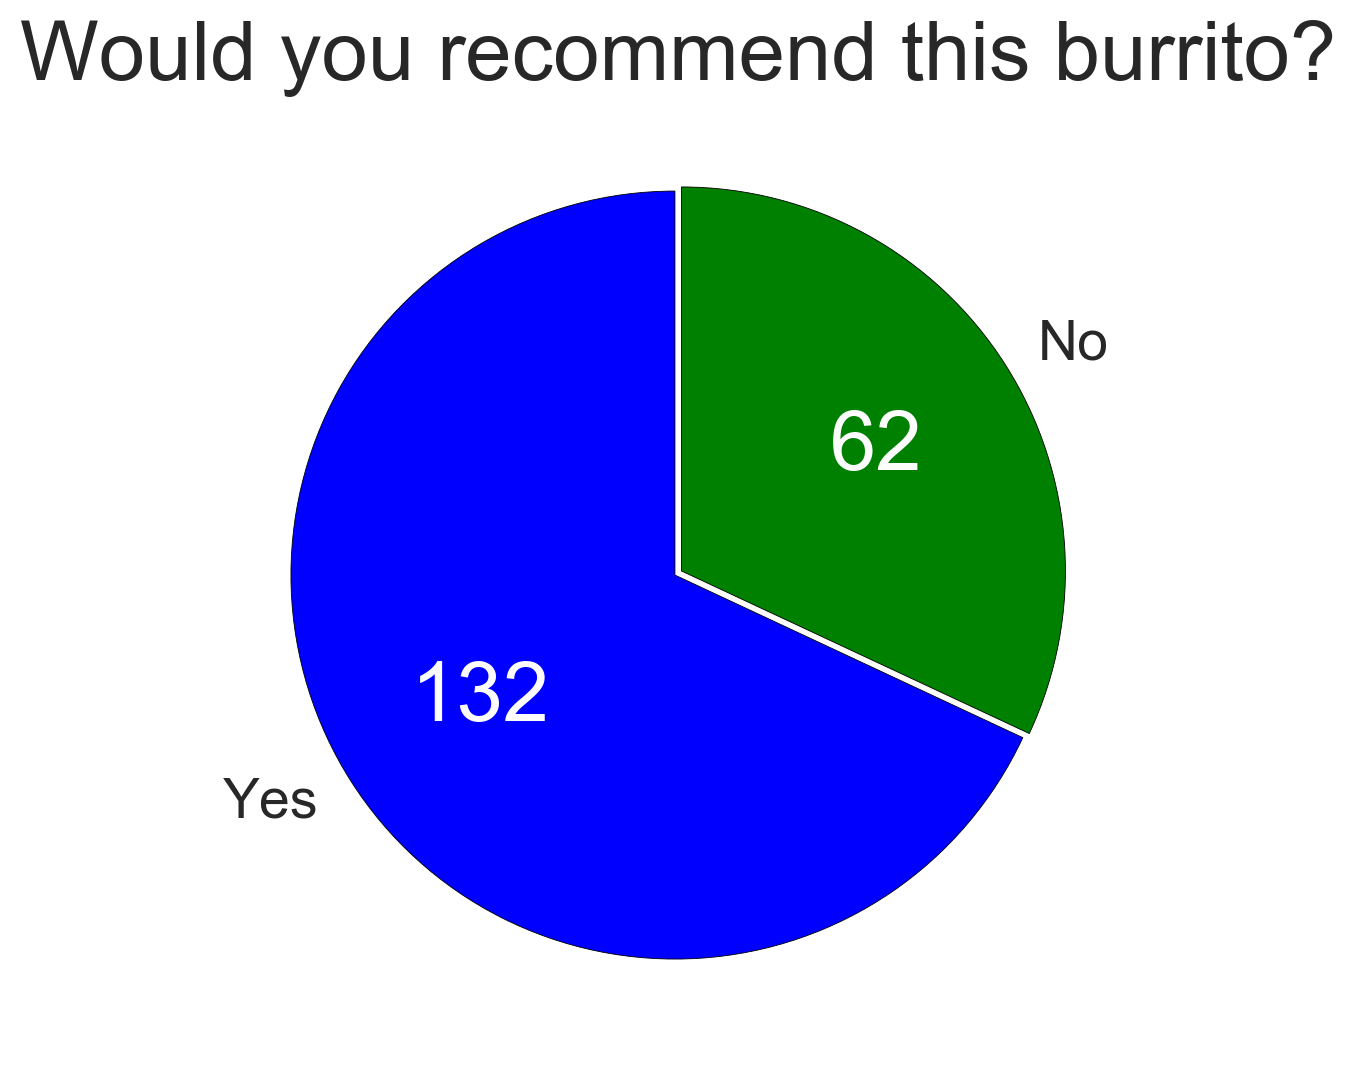

In [14]:
# Overall recommendations
plt.figure(figsize=(6,6))
ax = plt.axes([0.1, 0.1, 0.8, 0.8])

# The slices will be ordered and plotted counter-clockwise.
labels = ['Yes','No']
fracs = np.array([np.sum(df.Rec==labels[0]),np.sum(df.Rec==labels[1])])
explode=[.01]*len(labels)

patches, texts, autotexts = plt.pie(fracs, explode=explode, labels=labels,
                autopct=lambda(p): '{:.0f}'.format(p * np.sum(fracs) / 100), shadow=False, startangle=90)
                # The default startangle is 0, which would start
                # the Frogs slice on the x-axis.  With startangle=90,
                # everything is rotated counter-clockwise by 90 degrees,
                # so the plotting starts on the positive y-axis.

plt.title('Would you recommend this burrito?',size=30)
for t in texts:
    t.set_size(20)
for t in autotexts:
    t.set_size(30)
autotexts[0].set_color('w')
autotexts[1].set_color('w')

figname = 'recspie'
plt.savefig('C:/gh/fig/burrito/'+figname + '.png')

# PCA

In [15]:
dfpca = df[['Volume','Tortilla','Temp','Meat','Fillings','Meat:filling','Uniformity','Salsa','Synergy','Wrap']]

In [16]:
dfpca = dfpca.fillna(dfpca.mean())

In [17]:
# Normalize
dfpca = (dfpca - dfpca.mean()) / dfpca.std()
dfpca

,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap
0,-4.161415e-15,-0.566435,1.359848,-6.242362e-01,5.088369e-02,5.198766e-01,5.697333e-01,7.922960e-01,6.033365e-01,-0.000665
1,-4.161415e-15,-1.843170,-0.163892,-1.235965e+00,-1.192940e+00,-1.488199e+00,5.697333e-01,2.395314e-01,-1.080679e+00,0.910798
2,-4.161415e-15,-0.566435,-1.687631,-1.235965e+00,-5.710281e-01,1.021895e+00,5.697333e-01,-3.132333e-01,-5.193406e-01,0.910798
3,-4.161415e-15,-0.566435,-1.687631,-1.250746e-02,-5.710281e-01,5.198766e-01,1.476804e+00,7.922960e-01,6.033365e-01,0.910798
4,-4.161415e-15,0.710299,1.359848,5.992212e-01,5.088369e-02,1.021895e+00,1.476804e+00,-8.659980e-01,1.164675e+00,-0.000665
5,-4.161415e-15,-0.566435,0.344021,1.822679e+00,5.088369e-02,-9.861799e-01,-7.908732e-01,-8.659980e-01,6.033365e-01,-2.735056
6,-4.161415e-15,-1.843170,-0.671805,-6.242362e-01,-1.814852e+00,-9.861799e-01,-7.908732e-01,4.909536e-16,-1.642018e+00,-0.912129
7,-4.161415e-15,-1.204802,-0.671805,-6.242362e-01,-1.192940e+00,-4.841610e-01,1.161978e-01,4.909536e-16,-1.080679e+00,-0.912129
8,-4.161415e-15,-1.843170,0.851935,1.210950e+00,5.088369e-02,-1.990218e+00,-3.373377e-01,2.395314e-01,6.033365e-01,-1.823592
9,-4.161415e-15,-1.204802,-2.195544,-2.459422e+00,-5.710281e-01,1.021895e+00,-3.373377e-01,-1.971527e+00,-1.642018e+00,0.455066


In [18]:
# Color: Taco Stand, Lucha, Los Primos

In [19]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(dfpca)
print pca.components_
print pca.explained_variance_ratio_

[[-0.05981384 -0.29111686 -0.16792311 -0.4015175  -0.42091645 -0.35713543
  -0.30738913 -0.30307379 -0.46989618 -0.10197162]
 [ 0.56938166 -0.0448795  -0.35358779  0.18715362  0.24908273 -0.23284636
  -0.27594273  0.07911676  0.12390614 -0.54746994]]
[ 0.31561122  0.13451237]


In [20]:
np.sum(pca.components_,1)

array([-2.88075391, -0.24608542])

In [21]:
dfpca_proj = np.dot(pca.components_,dfpca.T)

In [22]:
np.sum(df.Location=='taco stand')

21

In [23]:
foo = 'abc'
bar = 'ba'
zoo = '123'
foo == 'abc' and bar == 'bac' or zoo == '123'

True

In [24]:
dfpca_proj[0][np.where(df.Location=='taco stand')]

array([-0.85410625, -2.06288946, -1.40917157, -1.04124885, -2.09544847,
       -0.50588883, -0.98618675, -0.75863015, -3.78744178, -1.17494138,
       -2.8128745 , -0.44187548, -1.16440769, -2.25003564, -0.61487219,
       -1.07887302, -0.24871672, -0.96294739, -0.74278888, -3.37969854,
       -3.07952042])

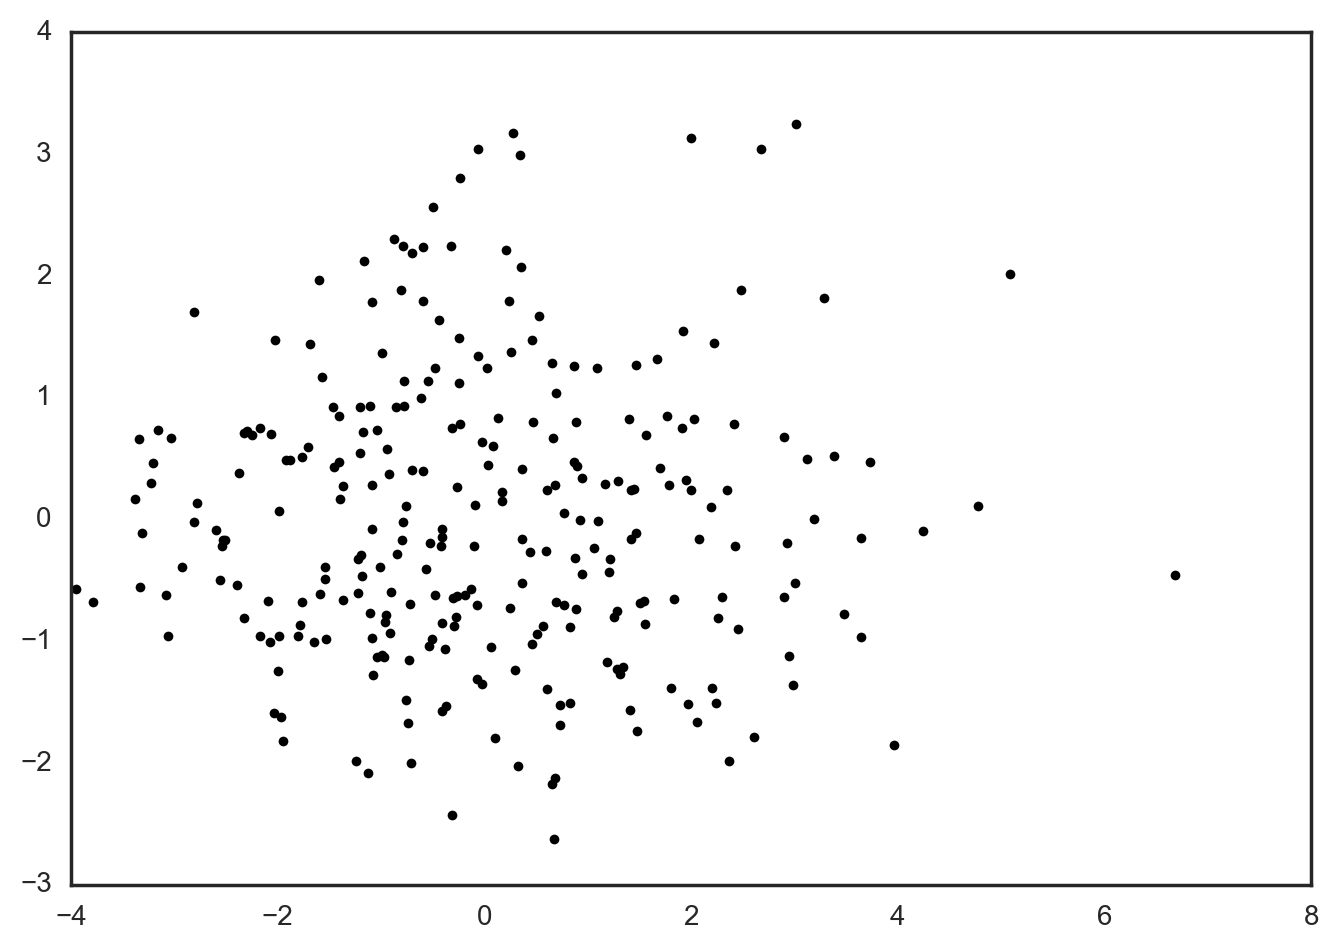

In [30]:
plt.plot(dfpca_proj[0],dfpca_proj[1],'k.')

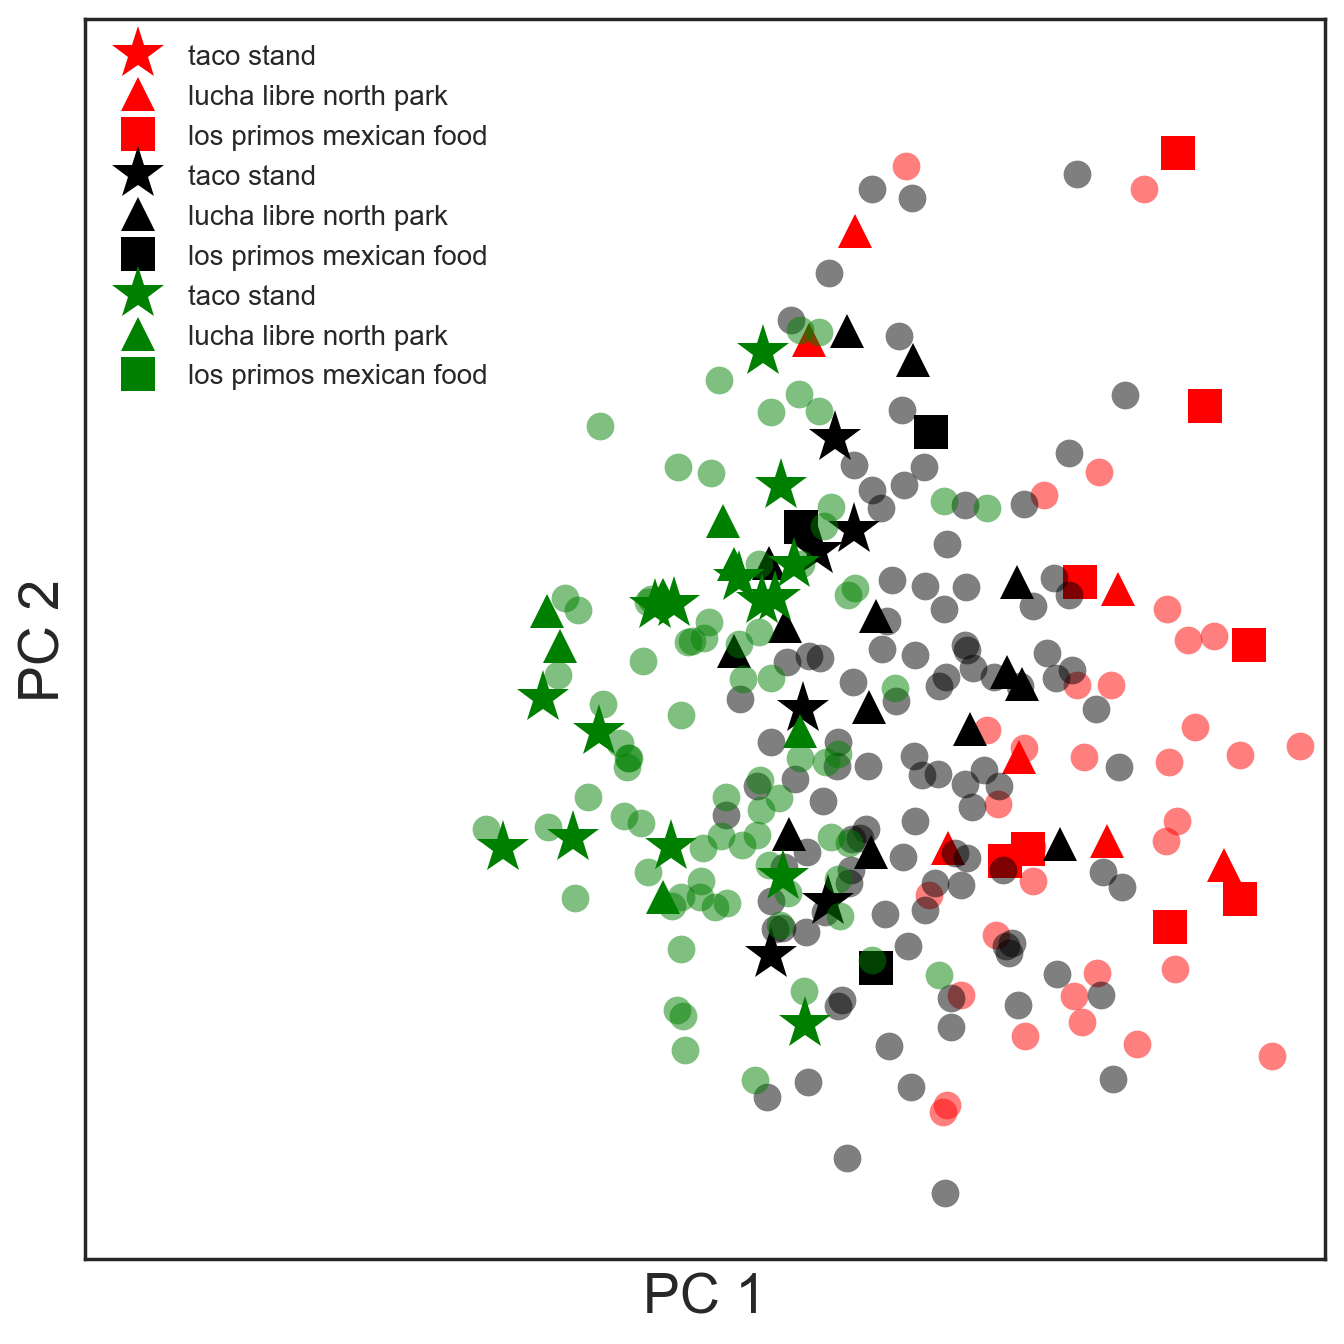

In [31]:
plt.figure(figsize=(8,8))
shops = ['taco stand','lucha libre north park','los primos mexican food']
shops_marker = ['*','^','s']
shops_ms = [20,12,12]
overallcutoffs = [-.1, 3, 4, 5.1]
overallcolors = ['r','k','g']


for o in range(len(overallcolors)):
    notshops = np.logical_and(df.Location != shops[0],np.logical_and(df.Location != shops[1],df.Location != shops[2]))
    orange = np.logical_and(df.overall>=overallcutoffs[o],df.overall<overallcutoffs[o+1])
    notshops = np.where(np.logical_and(notshops,orange))
    plt.plot(dfpca_proj[0][notshops],dfpca_proj[1][notshops],'.',color=overallcolors[o],alpha=.5,ms=20)
    for s in range(len(shops)):
        burridx = np.where(np.logical_and(df.Location==shops[s],np.logical_and(df.overall>=overallcutoffs[o],df.overall<overallcutoffs[o+1])))
        plt.plot(dfpca_proj[0][burridx],dfpca_proj[1][burridx],
                 shops_marker[s],color=overallcolors[o],ms=shops_ms[s],label = shops[s])
plt.xlim((-8,4.5))
plt.ylim((-3,4))
plt.xlabel('PC 1',size=20)
plt.ylabel('PC 2',size=20)
plt.xticks([])
plt.yticks([])
plt.legend(loc='best')

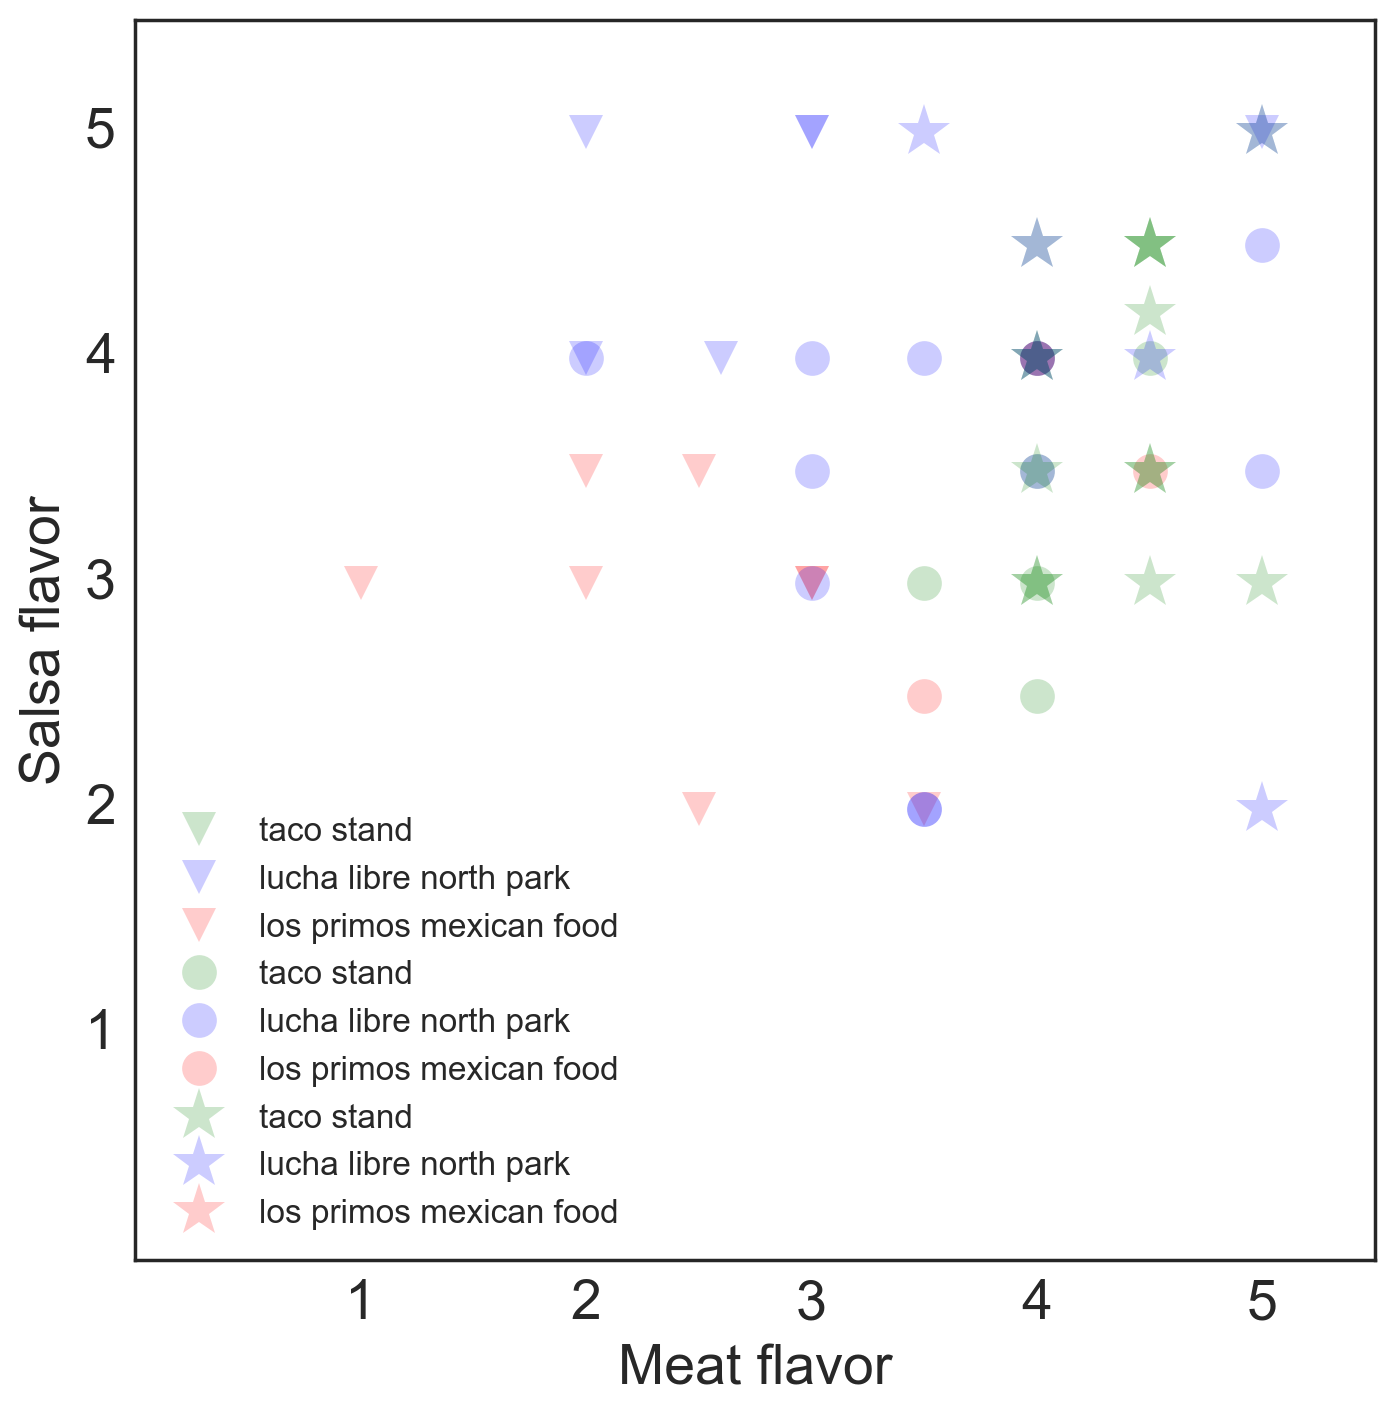

In [32]:
shopsalpha = [.2,.2,.2]
shops = ['taco stand','lucha libre north park','los primos mexican food']
overall_marker = ['v','.','*']
overall_ms = [12,25,20]
overallcutoffs = [-.1, 3, 4, 5.1]
shopscolors = ['g','b','r']

plt.figure(figsize=(8,8))
for o in range(len(overallcolors)):
    notshops = np.logical_and(df.Location != shops[0],np.logical_and(df.Location != shops[1],df.Location != shops[2]))
    orange = np.logical_and(df.overall>=overallcutoffs[o],df.overall<overallcutoffs[o+1])
    notshops = np.where(np.logical_and(notshops,orange))[0]
    #plt.plot(df.Meat[notshops],df.Fillings[notshops],'.',color=overallcolors[o],alpha=.2,ms=20)
    for s in range(len(shops)):
        burridx = np.where(np.logical_and(df.Location==shops[s],np.logical_and(df.overall>=overallcutoffs[o],df.overall<overallcutoffs[o+1])))[0]
        plt.plot(df.Meat[burridx],df.Salsa[burridx],
                 overall_marker[o],color=shopscolors[s],ms=overall_ms[o],alpha=shopsalpha[s],label=shops[s])
plt.xlim((0,5.5))
plt.ylim((0,5.5))
plt.xlabel('Meat flavor',size=20)
plt.ylabel('Salsa flavor',size=20)
plt.xticks(np.arange(1,6),size=20)
plt.yticks(np.arange(1,6),size=20)
plt.legend(loc='best',fontsize=12)

plt.savefig('C:/gh/fig/burrito/superscatter.png')